In [ ]:
Name  :Yoneshwar Babu hi
ASU ID:1220454365

![](DOPR1P1.png)


In [1]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)


In [28]:
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 9.8  # m/s2, gravity constant
BOOST_ACCEL = 12.0  # m/s2, thrust constant
#drag=0.5

In [29]:
# defining the dynamics of system

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action:
        action[0]: thrust in x direction. range (0, 1). 
                    1 = maximum thrust. 
                    0 = minimum thrust i.e zero.
          
        with respect to graph  
          
        action[1]: thrust in the direction of y axis. range (0, 1).
                   here at 0.5 there is no thrust, at 0 there is thrust in left side and at 1 thrust is in right side. 
        
        states:
        state[0] = x
        state[1] = xd_v velocity in x direction
        state[2] = y
        state[3] = yd_v velocity in y direction
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        # Taking gravity into consideration       
        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust of x and y directions are calculated respectively
        thrust_x = action[0]*2.0-1.0
        thrust_y = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0 , 0., 0.]) * thrust_x
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0. , 0., 1.0]) * thrust_y
        
        # Update velocity, both gravity, thrust of x and y are used
        state = state + delta_state_x + delta_state_y + delta_state_gravity
        
        # Update state 
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [30]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


In [31]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [32]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2


In [47]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 5 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        xd_v = data[:, 1]
        y1 = data[:, 2]
        xd_v = data[:, 3]
        tt = range(self.simulation.T)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_xx = data1[:, 0]
        thrust_yy = data1[:, 1]
        
        fig, graph = plt.subplots(1, 3, figsize=(20, 7))
        
        graph[0].plot(x1, y1)
        graph[0].plot(5, 20, '-ro', c='m', label='start')
        graph[0].plot(0, 0, '-ro', c='r', label='destination')
        graph[0].set_xlabel('x (m)')
        graph[0].set_ylabel('y (m)')
        graph[0].set(title='Displacement in X and Y')
        graph[0].grid()
        graph[0].legend()
        
        
        
        graph[1].plot(tt,xd_v, c='g', label='x velocity')
        graph[1].plot(tt,yd_v, c='r', label='y velocity')
        graph[1].set_xlabel('frame (0.1s)')
        graph[1].set_ylabel('v (m/s)')
        graph[1].set(title='Velocity plot')
        graph[1].grid()
        graph[1].legend()
        
        
        graph[2].plot(tt, thrust_xx, c='g', label='x thrust')
        graph[2].plot(tt, thrust_yy, c='r', label='y thrust')
        graph[2].set_xlabel('frame time)')
        graph[2].set_ylabel('thrust')
        graph[2].set(title='Thrust plot')
        graph[2].grid()
        graph[2].legend()
           
        fig.tight_layout()
       
        plt.show()

[1] loss: 4427.593


NameError: name 'yd_v' is not defined

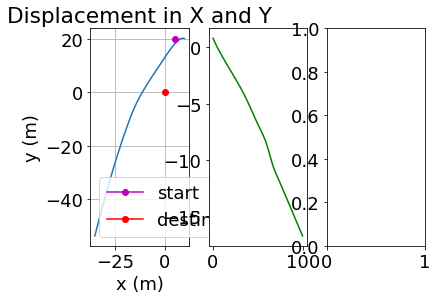

In [48]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(81)  # solve the optimization problem